(sec_Notebooks_QKD)= 
## Quantum Key Distribution - BB84 

:::{contents}
:local:
:depth: 1
:::
                                        

In [1]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

In [2]:
# Importamos el simulador. Con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

(sec_Notebooks_QKD_1)= 
## Introducción

El protocolo aprovecha el hecho de que medir un qubit puede cambiar su estado. Si Alice envía un qubit a Bob y un espía (Eve) intenta medirlo antes que Bob, existe la posibilidad de que la medición de Eve cambie el estado del qubit y Bob no reciba el estado del qubit que Alice envió.

Si Alice prepara un qúbit en el estado $| + \rangle$ ($0$ en la base $X$), y Bob lo mide en la base $X$, este mide con certeza el valor $0$. 

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


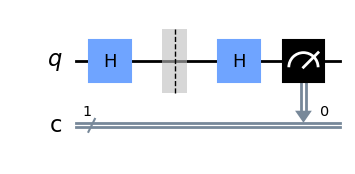

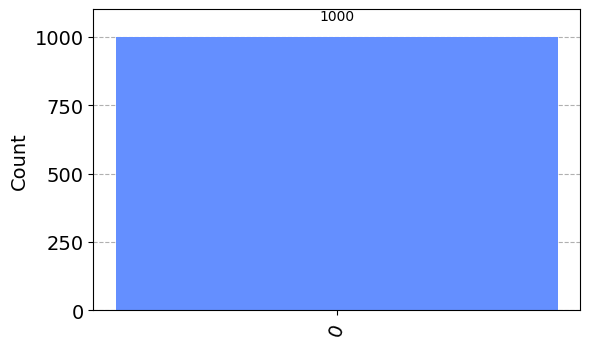

In [3]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw('mpl'))

t_qc = transpile(qc, backend = simulador) #, optimization_level = 3)
result = simulador.run(t_qc, shots = 1000).result()

Fig = plot_histogram(result.get_counts())
Fig.set_size_inches(6, 3.6)
Fig.tight_layout()
display(Fig)

Pero si Eve intenta medir en la base $Z$ antes de que el estado llegue a Bob, cambiará el estado del qúbit de $| + \rangle$ a $| 0 \rangle$ o $| 1 \rangle$, y Bob ya no está seguro de medir $0$:

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


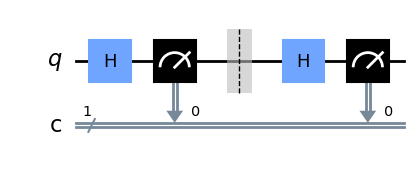

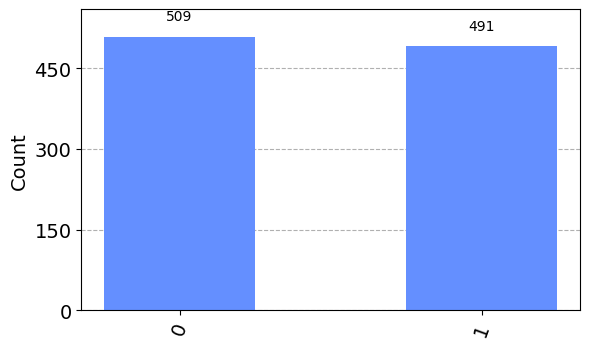

In [4]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw('mpl'))

t_qc = transpile(qc, backend = simulador) #, optimization_level = 3)
result = simulador.run(t_qc, shots = 1000).result()

Fig = plot_histogram(result.get_counts())
Fig.set_size_inches(6, 3.6)
Fig.tight_layout()
display(Fig)

Podemos ver aquí que Bob tiene ahora un 50% de posibilidades de medir 1, y si lo hace, él y Alice sabrán que hay algo mal en su canal.

El BB84 de QKD implica repetir este proceso suficientes veces como para que un espía tenga una probabilidad insignificante de salirse con la suya en esta interceptación. El protocolo es el siguiente:

- Paso 1: Alice elige dos cadenas aleatorias de 4N-bits. 

    $$
    \begin{array}{ll}
     1001101\dots \\
     0011101\dots
    \end{array}
    $$

- Paso 2: Alice usa estas cadenas para codificar los estado: la primera le dirá si tiene que enviar un $0$ o un $1$ y la segunda le dirás si ese valor tiene que ir codificado en la base $Z$ (si es $0$ en la segunda) o en la base $X$ (si es $1$ en la segunda). Es decir:

    $$
    \left. \begin{array}{ll}
    \text{Valores}: & 1001101\dots \\
    \text{Base}: &    0011101\dots
    \end{array} \right\} 
    \Rightarrow
    |1\rangle |0 \rangle | +\rangle |- \rangle |- \rangle | 0\rangle |- \rangle \dots
    $$

    Este mensaje es enviado a Bob.

- Paso 3: Bob genera una cadena aleatoria de 4N-bits. Esta cadena le dirá si tiene medir en $Z$ o en $X$ los estados que Alice le envió. Una vez medido, Bob mantiene este resultado privado.

- Paso 4: Bob y Alice comparten públicamente qué base han utilizado para cada qúbit. Si Bob midió un qúbit en la misma base en la que Alice lo preparó, lo utilizan para formar parte de su clave secreta compartida; de lo contrario, descartan la información de ese bit. En promedió, la clave en este punto tendrá 2N-bits.

- Paso 5: Por último, Bob y Alice comparten una muestra aleatoria de sus claves y, si las muestras coinciden, pueden estar seguros (con un pequeño margen de error) de que su transmisión se ha realizado correctamente. Esta muestra puede ser, por ejemplo, de N-bits, dejando una clave secreta de también N-bits.



(sec_Notebooks_QKD_2)= 
## Ejemplo de Qiskit: Sin interceptación   

Veamos primero cómo funciona el protocolo cuando no hay nadie escuchando, y luego veremos cómo Alice y Bob son capaces de detectar a un fisgón. Como siempre, empecemos importando todo lo que necesitamos.

Para generar claves pseudoaleatorias, usaremos la función randint de numpy. Para asegurarnos de que puedes reproducir los resultados, pondremos la semilla a 0:

In [5]:
np.random.seed(seed=0)

Llamaremos $N$ a la longitud del mensaje inicial de Alice. En este ejemplo, Alice enviará un mensaje de 100 qúbits de longitud:

In [6]:
N = 100

(sec_Notebooks_QKD_2.1)= 
## Paso 1

In [7]:
np.random.seed(seed=0)
N = 100
## Step 1
# Alice generates bits
alice_bits = randint(2, size = N)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


De momento, el conjunto de bits `alice_bits` sólo lo conoce Alice

(sec_Notebooks_QKD_2.2)= 
## Paso 2

Alice alije codificar cada bit en un qúbit en las bases $Z$ o $X$ aleatoriamente, y almacena las elecciones de bases en una lista `alice_bases`. En este caso, el $0$ significa **perparar base $Z$**, y el 1 significa **preparar en la base $X$**:

In [8]:
np.random.seed(seed=0)
n = 100
## Step 1
#Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases)

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


Alice también mantiene este conocimiento privado. 

La función `encode_message` a continuación, crea una lista de QuantumCircuits, cada uno representando un único qubit en el mensaje de Alice:

In [9]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [10]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

Podemos ver que el primer bit en `alices_bits` es 0, y la base en la que codifica esto es la base $X$ (representada por 1)

In [11]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 0
basis = 1


Y si vemos el primer circuito del mensaje (que representa el primer qúbit del mensaje de Alice), podemos verificar que Alice ha preparado un qúbit en el estado $| + \rangle$

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


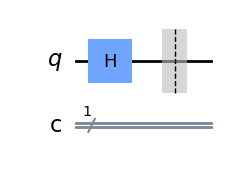

In [12]:
message[0].draw('mpl')

Este mensaje de qúbits se envía entonces a Bob a través del canal cuántico de Eve, es decir, es información susceptible de ser interceptada.

(sec_Notebooks_QKD_2.3)= 
## Paso 3

Bob mide cada qúbit aleatoriamente en las bases $X$ e $Z$ y almacena el resultado.

In [13]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


`bob_bases` almacena la elección de Bob sobre con qué base mide cada qúbit.

A continuación, la función `measure_message` aplica la medición correspondiente y simula el resultado de la medición de cada qúbit. Almacenamos los resultados de la medición en `bob_results`.

In [14]:
def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        result = aer_sim.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [15]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
print(bob_results)

[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]


Podemos ver que el circuito en `message[0]` (representado el qúbit 0) tiene un medidor en la base $X$ añadido por Bob.

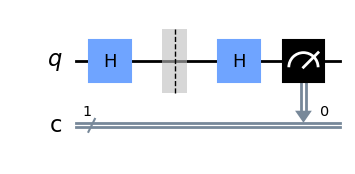

In [16]:
message[0].draw('mpl')

(sec_Notebooks_QKD_2.4)= 
## Paso 4

Después de esto, Alice revela (a través del canal de Eve) qué qubits fueron codificados en qué base, y Bob revela en qué base midió cada qubit.

Si Bob midió un bit en la misma base en la que Alice lo preparó, esto significa que la entrada en `bob_results` coincidirá con la entrada correspondiente en `alice_bits`, y pueden usar ese bit como parte de su clave. Si midieron en bases diferentes, el resultado de Bob es aleatorio, y ambos tiran esa entrada. Aquí hay una función `remove_garbage` que hace esto por nosotros.

In [17]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

Alice y Bob descartan los bits inútiles y utilizan los restantes para formar sus claves secretas:

In [18]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


(sec_Notebooks_QKD_2.5)= 
## Paso 5

Por último, Bob y Alice comparan una selección aleatoria de los bits de sus claves para asegurarse de que el protocolo ha funcionado correctamente:

In [19]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

Alice y Bob las difunden públicamente y las eliminan de sus claves, ya que dejan de ser secretas:

In [20]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Si el protocolo ha funcionado correctamente sin interferencias, sus muestras deberían coincidir:

In [21]:
bob_sample == alice_sample

True

Si sus muestras coinciden, significa (con alta probabilidad) `alice_key == bob_key`. Ahora comparten una clave secreta que pueden utilizar para cifrar sus mensajes. 

El *con alta probabilidad* hace referencia que si la longitud de clave que comparan es corta, pueden tener mala suerte y que coincida incluso habiendo un fisgón. Por eso es importante que comparen un segmento de clave relativamente grande.

In [22]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
key length = 33


(sec_Notebooks_QKD_2.6)= 
## Tabla de conocimiento

Veamos en cada paso del algoritmo quien sabe cada cadena secreta:

- Paso 1: Alice construye su clave 

<table>
    <thead>
        <tr>
            <th>Paso</th>
            <th>Conocimiento de Alices</th>
            <th>Transmitido en el canal de Eve</th>
            <th>Conocimiento de Bob</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td align="center">Paso 1</td>
            <td align="center"> <code>alice_bits</code></td>
            <td align="center"></td>
            <td align="center"></td>
        </tr>
    </tbody>
</table>

- Paso 2: Elije las bases y codifica el mensaje

<table>
    <thead>
        <tr>
            <th>Paso</th>
            <th>Conocimiento de Alices</th>
            <th>Transmitido en el canal de Eve</th>
            <th>Conocimiento de Bob</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 align="center">Paso 2</td>
            <td align="center"><code>alice_bases</code></td>
            <td align="center"></td>
            <td align="center"></td>
        </tr>
        <tr>
            <td align="center">Mensaje</td>
            <td align="center">Mensaje</td>
            <td align="center">Mensaje</td>
        </tr>
    </tbody>
</table>

- Paso 3: Bob elije unas bases y mide

<table>
    <thead>
        <tr>
            <th>Paso</th>
            <th>Conocimiento de Alices</th>
            <th>Transmitido en el canal de Eve</th>
            <th>Conocimiento de Bob</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 align="center">Paso 3</td>
            <td align="center"></td>
            <td align="center"></td>
            <td align="center"><code>bob_bases</code></td>
        </tr>
        <tr>
            <td align="center"></td>
            <td align="center"></td>
            <td align="center"><code>bob_result</code></td>
        </tr>
    </tbody>
</table>

- Paso 4: Bob y Alice hacen públicas las bases con las que han medido y descartan los bit en los que las bases no coinciden, quedándose así con las claves.

<table>
    <thead>
        <tr>
            <th>Paso</th>
            <th>Conocimiento de Alices</th>
            <th>Transmitido en el canal de Eve</th>
            <th>Conocimiento de Bob</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=3 align="center">Paso 4</td>
            <td align="center"></td>
            <td align="center"><code>alice_bases</code></td>
            <td align="center"><code>alice_bases</code></td>
        </tr>
        <tr>
            <td align="center"><code>bob_bases</code></td>
            <td align="center"><code>bob_bases</code></td>
            <td align="center"></td>
        </tr>
        <tr>
            <td align="center"><code>alice_key</code></td>
            <td align="center"></td>
            <td align="center"><code>bob_key</code></td>
        </tr>
    </tbody>
</table>

- Paso 5: Alice y Bob revelan una muestra de sus claves. Si coinciden, el resto de bit conforman la clave.

<table>
    <thead>
        <tr>
            <th>Paso</th>
            <th>Conocimiento de Alices</th>
            <th>Transmitido en el canal de Eve</th>
            <th>Conocimiento de Bob</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=3 align="center">Paso 5</td>
            <td align="center"><code>bob_sample</code></td>
            <td align="center"><code>bob_sample</code></td>
            <td align="center"><code>bob_sample</code></td>
        </tr>
        <tr>
            <td align="center"><code>alice_sample</code></td>
            <td align="center"><code>alice_sample</code></td>
            <td align="center"><code>alice_sample</code></td>
        </tr>
        <tr>
            <td align="center">Clave compartida</td>
            <td align="center"></td>
            <td align="center">Clave compartida</td>
        </tr>
    </tbody>
</table>

(sec_Notebooks_QKD_3)= 
# Ejemplo de Qiskit: Con interceptación 

Veamos ahora cómo Alice y Bob pueden saber si Eve ha intentado escuchar su mensaje cuántico. Repetimos los mismos pasos que sin interferencias, pero antes de que Bob reciba sus qubits, Eve intentará extraer alguna información de ellos. Pongamos una semilla diferente para obtener un conjunto específico de resultados "aleatorios" reproducibles:

In [23]:
np.random.seed(seed=3)

(sec_Notebooks_QKD_3.1)= 
## Paso 1 y 2

Alice genera un set de bits aleatorios y elije codificar cada bit en un qúbit en las bases $Z$ o $X$ aleatoriamente, y almacena las elecciones de bases en una lista `alice_bases`. En este caso, el $0$ significa **perparar base $Z$**, y el 1 significa **preparar en la base $X$**:

In [24]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
print(alice_bits)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]
[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]


En este caso, el primer qúbit se encuentra en el estado $| + \rangle$

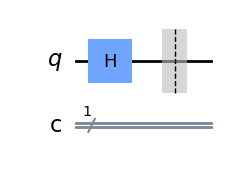

In [25]:
message[0].draw('mpl')

(sec_Notebooks_QKD_3.2)= 
## Intercepción

Eve intercepta el mensaje cuando pasa por su canal. Intenta medir los qubits en una selección aleatoria de bases, del mismo modo que Bob lo hará más tarde.

In [26]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(intercepted_message)

[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]


Podemos ver el caso del qubit 0 a continuación; la elección aleatoria de base de Eve no es la misma que la de Alice, y esto cambiará el estado del qubit de $| + \rangle$, a un estado aleatorio en la base $Z$, con un 50% de probabilidad de $| 0 \rangle$ o $| 1 \rangle$:

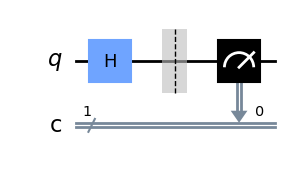

In [27]:
message[0].draw('mpl')

(sec_Notebooks_QKD_3.3)= 
## Paso 3

A continuación, Eve pasa los qubits a Bob, que los mide al azar. En este caso, Bob eligió (por azar) medir en la misma base en la que Alice preparó el qubit. Sin interceptación, Bob tendría garantizado medir 0, pero como Eve intentó leer el mensaje ahora tiene un 50% de posibilidades de medir 1 en su lugar.

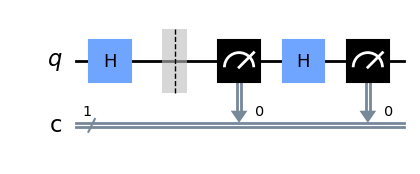

In [28]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

message[0].draw('mpl')

(sec_Notebooks_QKD_3.4)= 
## 3.4 - Pasos 4 y 5

Bob y Alice revelan sus elecciones de bases y descartan los bits inútiles. 

Bob y Alice comparan la misma selección aleatoria de sus claves para ver si los qubits fueron interceptados.

In [29]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [30]:
bob_sample == alice_sample

False

La clave de Bob y la de Alice no coinciden. Sabemos que esto se debe a que Eve intentó leer el mensaje entre los pasos 2 y 3, y cambió los estados de los qúbits. Por lo que Alice y Bob saben, esto podría deberse al ruido en el canal, pero en cualquier caso deben desechar todos sus resultados e intentarlo de nuevo: el intento de interceptación de Eve ha fallado.